# notebook to load lloyds matlab SLM masks and measure the power produced by each. This worked for me with power PV=700 

In [1]:
import sys 
sys.path.append(r'C:\Users\User\Documents\Code\blimp\sdk')
from slm_sdk import SLMsdk
import time
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
from random import shuffle
import visa # provides generic usb interface to the powermeter
from ThorlabsPM100 import ThorlabsPM100 # actually knows how to talk to the powermeter
from sklearn.metrics.pairwise import euclidean_distances
import scipy.io as sio
%matplotlib notebook

In [2]:
sdk = SLMsdk()
sdk.SLM_connect()

SLM connection established


In [3]:
#get the masks from lloyds script
mask_path = r'F:\Data\rlees\2019-02-18\3d_weighting\PhaseMasks'
mask_files = [join(mask_path,f) for f in listdir(mask_path) if isfile(join(mask_path, f))]

In [4]:
class DigitalPowerMeasurer:
    """
    This class takes analog devices on an AI card, a usb connection to the power meters, 
    a PrairieLink, and xmls and gpls to definethe SLM experiment.
    It then fires the experiment once to find the best power range, 
    initializes the analog devices, starts the SLM experiments and listens to the analog inputs.
    returns a power range array and the analog input array."""
    
    def __init__(self, visa_resource_manager, power_meter, meter_wavelength):
        
        self.rm = visa_resource_manager
        
        # create power_meters
        self.instrument = rm.open_resource(power_meter)
        self.power_meter = ThorlabsPM100(inst=self.instrument)
        
        
        # set the power meter wavelength
        self.power_meter.sense.correction.wavelength = meter_wavelength
        #let the wavelength change
        time.sleep(3)

    def measure(self):
        """
        laser name needs to match a laser name in PrairieView
        Wavelength needs to be accessible trhough the PrairieView 2P laser tab
        take {laser_name:laser_power[PV]} dictionary and perform measurement with this power for 3s"""

        # use USB correction to measure current power
        power = self.power_meter.read

        return power

In [5]:
# Search for PowerMeters
rm=visa.ResourceManager()
resource_list = rm.list_resources()
print(resource_list[0])


USB0::0x1313::0x8079::P1003857::INSTR


In [6]:
#connect to the power meter

# set the power meter wavelength
meter_wavelength = 1040
# create powermeter, assume that it is the first object showing up in the above list
pm100 = DigitalPowerMeasurer(rm, resource_list[0], meter_wavelength)


In [8]:
mask_powers = []

for mask in mask_files:
    sdk.load_mask(mask)
    time.sleep(0.5)
    power = pm100.measure()
    print(power)
    mask_powers.append(power)
    time.sleep(0.5)

C:\Users\User\Anaconda3\lib\site-packages\pyvisa\resources\messagebased.py:568: FutureWarning: ask is deprecated and will be removed in 1.10, use query instead.
  '1.10, use query instead.', FutureWarning)


0.15603888
0.148176402
0.148478791
0.149990782
0.153014868
0.153014868
0.152258828
0.156946018
0.15891169
0.170251727
0.177055672
0.184464574
0.189000577
0.184010908
0.176299721
0.172368482
0.164354831
0.157702059
0.148781255
0.146210834
0.145908445
0.146210834
0.146210834
0.146362022
0.148630068
0.152712405
0.154526874
0.159516454
0.158609211
0.166471675
0.167378917
0.180835724
0.192024574
0.186127767
0.184464574
0.177962914
0.169193298
0.164657295
0.157097206
0.151351601
0.150746837
0.149688408
0.149083644
0.148932457
0.147722825
0.152712405
0.157550871
0.161330834
0.164959684
0.16541326
0.166622877
0.177206874
0.18491815
0.188546911
0.198072568
0.190361381
0.179928482
0.172670871
0.161179632
0.155585214
0.151351601
0.149839595
0.149990782
0.151654065
0.153619632
0.154526874
0.157399684
0.163750067
0.169495687
0.175997347
0.174182862
0.177509338
0.180382147
0.183406144
0.195804521
0.19716534
0.190814957
0.183254957
0.172822058
0.169495687
0.161482021
0.157097206
0.153014868
0.1475716

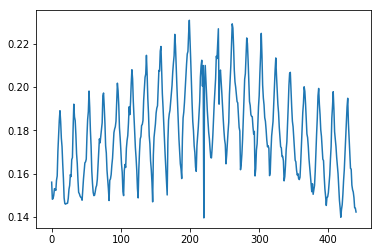

In [9]:
plt.plot(mask_powers)

In [19]:
sdk.SLM_disconnect()

Disconnected from SLM and powered down


In [11]:
sio.savemat(r'C:\Users\User\Documents\Code\SLM\2019-02-18_400x400grid_20pxSpacing_RLJR_2DWeighting.mat', {'mask_powers':mask_powers})